<a href="https://colab.research.google.com/github/torrozz/Graduation/blob/main/Graduation_verLung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cài đặt thư viện Kaggle CLI
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()  # Tải lên file kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nguyntntjason","key":"a77661f4fc309da9ac836ae66d9cbd10"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Tải dataset ung thư phổi từ Kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.74G/1.76G [00:13<00:00, 252MB/s]
100% 1.76G/1.76G [00:13<00:00, 143MB/s]


In [ ]:
# Giải nén dataset
!unzip -q lung-and-colon-cancer-histopathological-images.zip -d lung_colon_data


In [ ]:
# Cài đặt thư viện fastai nếu chưa có
!pip install -q fastai

# Import thư viện cần thiết
from fastai.vision.all import *
import pandas as pd
from pathlib import Path


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.4 MB/s eta 0:00:00


In [ ]:
# =================================================================
# BƯỚC 1: TẠO DATASET LUNG VỚI 2 CLASSES (CANCER + NORMAL)
# =================================================================

# Đường dẫn gốc và đích
src_path = "lung_colon_data/lung_colon_image_set/lung_image_sets"
dst_path = "lung_data"

# Xóa thư mục cũ nếu tồn tại và tạo mới
if os.path.exists(dst_path):
    shutil.rmtree(dst_path)

# Tạo cấu trúc thư mục mới
os.makedirs(dst_path)
os.makedirs(os.path.join(dst_path, "cancer"))  # Gộp aca + scc
os.makedirs(os.path.join(dst_path, "normal"))  # lung_n

print("📁 Đang tạo dataset lung với 2 classes...")

# Copy lung_n (normal) vào thư mục normal
lung_n_src = os.path.join(src_path, "lung_n")
lung_n_dst = os.path.join(dst_path, "normal")
if os.path.exists(lung_n_src):
    for img_file in os.listdir(lung_n_src):
        shutil.copy2(os.path.join(lung_n_src, img_file), os.path.join(lung_n_dst, img_file))
    print(f"✅ Copied lung_n: {len(os.listdir(lung_n_dst))} images")

# Copy lung_aca (adenocarcinoma) vào thư mục cancer
lung_aca_src = os.path.join(src_path, "lung_aca")
cancer_dst = os.path.join(dst_path, "cancer")
if os.path.exists(lung_aca_src):
    for img_file in os.listdir(lung_aca_src):
        # Thêm prefix "aca_" để tránh trùng tên file
        new_name = f"aca_{img_file}"
        shutil.copy2(os.path.join(lung_aca_src, img_file), os.path.join(cancer_dst, new_name))
    print(f"✅ Copied lung_aca: {len([f for f in os.listdir(cancer_dst) if f.startswith('aca_')])} images")

# Copy lung_scc (squamous cell carcinoma) vào thư mục cancer
lung_scc_src = os.path.join(src_path, "lung_scc")
if os.path.exists(lung_scc_src):
    for img_file in os.listdir(lung_scc_src):
        # Thêm prefix "scc_" để tránh trùng tên file
        new_name = f"scc_{img_file}"
        shutil.copy2(os.path.join(lung_scc_src, img_file), os.path.join(cancer_dst, new_name))
    print(f"✅ Copied lung_scc: {len([f for f in os.listdir(cancer_dst) if f.startswith('scc_')])} images")

# Kiểm tra kết quả final
print("\n📊 DATASET SUMMARY:")
for label in os.listdir(dst_path):
    label_path = os.path.join(dst_path, label)
    if os.path.isdir(label_path):
        num_images = len(os.listdir(label_path))
        print(f"{label}: {num_images} images")

total_images = sum(len(os.listdir(os.path.join(dst_path, label)))
                  for label in os.listdir(dst_path)
                  if os.path.isdir(os.path.join(dst_path, label)))
print(f"Total: {total_images} images")

# =================================================================

📁 Đang tạo dataset lung với 2 classes...
✅ Copied lung_n: 5000 images
✅ Copied lung_aca: 5000 images
✅ Copied lung_scc: 5000 images

📊 DATASET SUMMARY:
normal: 5000 images
cancer: 10000 images
Total: 15000 images



🔄 Creating DataLoaders...
Classes: ['cancer', 'normal']
Training samples: 12000
Validation samples: 3000

🖼️ Sample batch:


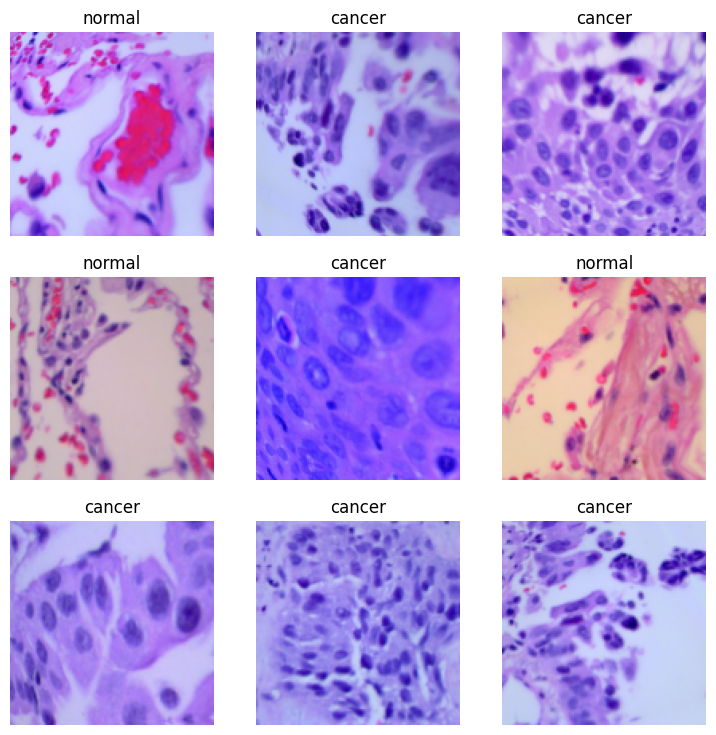

In [ ]:
# BƯỚC 2: TẠO DATALOADERS (GIỐNG NHU CODE COLON CỦA BẠN)
# =================================================================

print("\n🔄 Creating DataLoaders...")

dls = ImageDataLoaders.from_folder(
    "lung_data",
    valid_pct=0.2,        # 20% cho validation
    seed=42,              # Đảm bảo reproducibility
    item_tfms=Resize(224), # Resize tất cả ảnh về 224x224
    batch_tfms=aug_transforms(
        flip_vert=True,       # Lật dọc
        max_rotate=20,        # Xoay ảnh tối đa ±20 độ
        max_zoom=1.2,         # Phóng to ảnh tối đa 20%
        max_lighting=0.3,     # Tăng giảm độ sáng tối
        max_warp=0.3,         # Làm biến dạng nhẹ
        p_affine=0.75,        # Xác suất áp dụng biến dạng hình học
        p_lighting=0.75       # Xác suất thay đổi ánh sáng
    ),
    bs=32
)

# Xem lại các nhãn
print("Classes:", dls.vocab)
print(f"Training samples: {len(dls.train_ds)}")
print(f"Validation samples: {len(dls.valid_ds)}")

# Hiển thị một batch mẫu
print("\n🖼️ Sample batch:")
dls.show_batch(max_n=9)

# =================================================================


🚀 Initializing model...


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.4MB/s]



📈 Finding optimal learning rate...



🎯 Starting training...


epoch,train_loss,valid_loss,accuracy,time
0,0.089715,0.039943,0.992333,02:19


epoch,train_loss,valid_loss,accuracy,time
0,0.038105,0.011925,0.997333,02:25
1,0.011931,0.002506,0.999000,02:22
2,0.008461,0.008821,0.998000,02:22
3,0.006703,0.001133,0.999333,02:22
4,0.006491,0.000260,1.000000,02:20


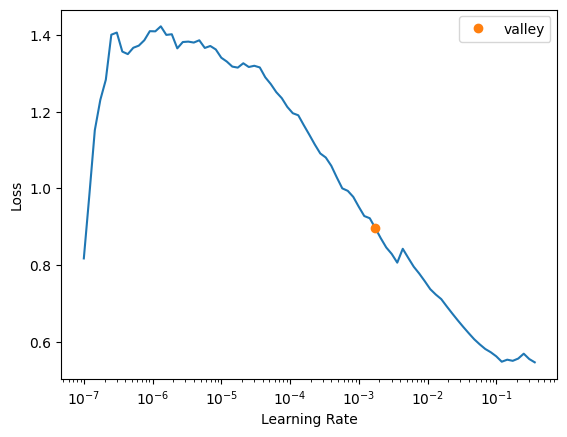

In [ ]:
# BƯỚC 3: TRAINING MODEL (GIỐNG NHU CODE COLON CỦA BẠN)
# =================================================================

print("\n🚀 Initializing model...")

# Khởi tạo mô hình với ResNet50
learn = cnn_learner(dls, resnet50, metrics=accuracy)

# Tìm learning rate tối ưu
print("\n📈 Finding optimal learning rate...")
learn.lr_find()

# Fine-tune model với learning rate được đề xuất
print("\n🎯 Starting training...")
learn.fine_tune(5, base_lr=2e-3)



📊 Model Evaluation:



Most confused predictions:



💾 Saving model...
✅ Model saved as 'lung_cancer_model.pkl'

🎉 TRAINING COMPLETED!
📋 Summary:
- Dataset: Lung images (Cancer vs Normal)
- Cancer class: lung_aca + lung_scc (10,000 images)
- Normal class: lung_n (5,000 images)
- Architecture: ResNet50 with transfer learning
- Training: 5 epochs fine-tuning
- Model saved: lung_cancer_model.pkl


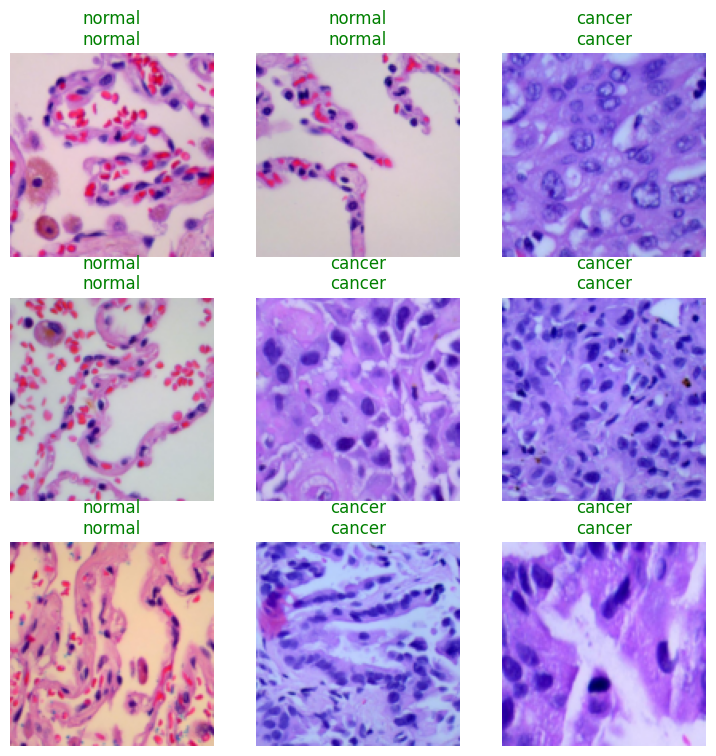

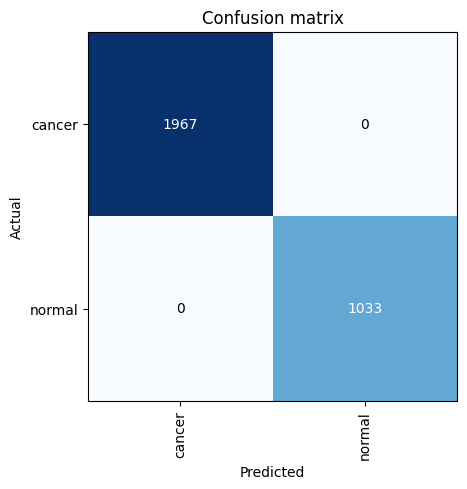

In [ ]:
# BƯỚC 4: ĐÁNH GIÁ MODEL
# =================================================================

print("\n📊 Model Evaluation:")

# Hiển thị kết quả predictions
learn.show_results()

# Tạo confusion matrix và analysis
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Xem những trường hợp model confused nhất
print("\nMost confused predictions:")
interp.most_confused(min_val=2)

# Lưu model
print("\n💾 Saving model...")
learn.export('lung_cancer_model.pkl')
print("✅ Model saved as 'lung_cancer_model.pkl'")

print("\n🎉 TRAINING COMPLETED!")
print("📋 Summary:")
print("- Dataset: Lung images (Cancer vs Normal)")
print("- Cancer class: lung_aca + lung_scc (10,000 images)")
print("- Normal class: lung_n (5,000 images)")
print("- Architecture: ResNet50 with transfer learning")
print("- Training: 5 epochs fine-tuning")
print("- Model saved: lung_cancer_model.pkl")

In [ ]:
learn.export('/content/lung_cancer_model.pkl')

📤 Upload ảnh bất kỳ (png/jpg/tif...)


Saving lungn48.jpeg to lungn48.jpeg


🔍 Kết quả dự đoán: normal
🔴 Có ung thư (cancer): 0.0000 | 🟢 Không ung thư (normal): 1.0000


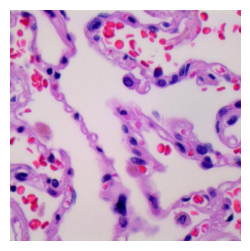

In [ ]:
from fastai.vision.all import *
from google.colab import files
from PIL import Image

# --- 1. Load mô hình colon ---
learn_inf = load_learner("/content/lung_cancer_model.pkl")  # Đảm bảo đúng đường dẫn model

# --- 2. Upload ảnh ---
print("📤 Upload ảnh bất kỳ (png/jpg/tif...)")
uploaded_img = files.upload()
img_filename = next(iter(uploaded_img))  # Lấy tên file

# --- 3. Nếu là ảnh .tif thì chuyển sang RGB ---
img_ext = img_filename.split('.')[-1].lower()

if img_ext == 'tif':
    img_raw = Image.open(img_filename).convert('RGB')
    tif_path = img_filename.rsplit('.', 1)[0] + ".tif"
    img_raw.save(tif_path)
    img_filename = tif_path  # Cập nhật lại tên file

# --- 4. Dự đoán ---
img = PILImage.create(img_filename)
pred_class, pred_idx, probs = learn_inf.predict(img)

# --- 5. Hiển thị ---
img.show(figsize=(3,3))
print(f"🔍 Kết quả dự đoán: {pred_class}")
print(f"🔴 Có ung thư (cancer): {probs[0]:.4f} | 🟢 Không ung thư (normal): {probs[1]:.4f}")
